In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Remap label values to bins of score

**Current Labels & Coresponding Movie Score by User:**

```score: label value```
```{0.5: 0,
 1.0: 1,
 1.5: 2,
 2.0: 3,
 2.5: 4,
 3.0: 5,
 3.5: 6,
 4.0: 7,
 4.5: 8,
 5.0: 9}```

 **Remap to:** 
 ```{0.5 to 3.0 inclusive: 0 ; 3.5 to 5 inclusive: 1} ```

In [ ]:
# Load all data
X_train_trf1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_train_trf1_v3.csv')
X_val_trf1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_val_trf1_v3.csv')
X_test_trf1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_test_trf1_v3.csv')


In [ ]:
movielist = pd.concat([X_train_trf1.loc[:,['primaryTitle', 'movieId_ori','movieId']],
           X_val_trf1.loc[:,['primaryTitle', 'movieId_ori','movieId']],
           X_test_trf1.loc[:,['primaryTitle', 'movieId_ori','movieId']]
], axis = 0).drop_duplicates()

In [ ]:
userlist = pd.concat([X_train_trf1.loc[:,['userId', 'userId_ori']],
           X_val_trf1.loc[:,['userId', 'userId_ori']],
           X_test_trf1.loc[:,['userId', 'userId_ori']]
], axis = 0).drop_duplicates()

userlist 

,userId,userId_ori
0,0.758627,123711
1,0.176422,30111
2,0.633602,103611
3,0.191045,32462
4,0.600113,98227
...,...,...
650,0.572919,93855
667,0.408931,67491
668,0.894942,145626
695,0.186778,31776


In [ ]:
for i in [X_train_trf1,X_val_trf1,X_test_trf1]:
  print(i.shape)

X_test_complete = X_test_trf1.loc[:,['primaryTitle', 'userId_ori',
                                     'userId']]

for i in [X_train_trf1,X_val_trf1,X_test_trf1]:
  i.drop(['rating_month__1',
 'rating_month__2',
 'rating_month__3',
 'rating_month__4',
 'rating_month__5',
 'rating_month__6',
 'rating_month__7',
 'rating_month__8',
 'rating_month__9',
 'rating_month__10',
 'rating_month__11',
 'rating_month__12',
 'rating_year',
 'primaryTitle',
 'movieId_ori',
 'userId_ori'], axis=1, inplace = True)

#X_train_trf1 = X_train_trf1.to_numpy()
#X_val_trf1 = X_val_trf1.to_numpy()
#X_test_trf1 = X_test_trf1.to_numpy() 

y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_train_nn_v3.csv').to_numpy().flatten()
y_val= pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_val_nn_v3.csv').to_numpy().flatten()
y_test= pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_test_nn_v3.csv').to_numpy().flatten()

# Convert 9bins to 2bins func
# index 0 to 6: movie scores given by user, where 0:0.5, 1:1, 2:1.5, 3:2, 4:2.5, 5: 3,  
def nineToTwoBins(y_dataset):
    y_dataset = (y_dataset >= 3.5).astype(int)
    return y_dataset

(232599, 43)
(41047, 43)
(68433, 43)


In [ ]:
X_test_complete.shape

(68433, 3)

In [ ]:
for i in [X_train_trf1,X_val_trf1,X_test_trf1]:
  print(i.shape)

(232599, 27)
(41047, 27)
(68433, 27)


In [ ]:
pd.Series(y_train).value_counts()

3.0    53122
4.0    46565
3.5    39189
2.5    22437
2.0    22227
4.5    13954
5.0    13402
1.0     9206
1.5     7165
0.5     5332
dtype: int64

In [ ]:
# Convert to binary bins, 0 if score < 3.5, 1 if score >= 3.5:
y_train = (nineToTwoBins(y_train))
y_val = (nineToTwoBins(y_val))
y_test = (nineToTwoBins(y_test))


# Import Libraries for Keras

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import DenseFeatures

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.layers import Dropout

In [ ]:
num_classes = len(np.unique(y_train)
)
print(num_classes)

num_features = np.shape(X_train_trf1)[1] # number of features
num_features

2


27

# Define Plotting Functions & Training Functions

In [ ]:
# Fitting & Plotting Functions
def train_model(model, X_train, y_train, 
                X_val,y_val, epochs,
                batch_size=None):
  """Train the model by feeding it data."""

  history = model.fit(x=X_train, y=y_train, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_data=(X_val, y_val)
                      )
  
  return history   

def plot_curve(hist):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  epochs = hist.epoch
  f, ax = plt.subplots(nrows = 2, ncols=2, figsize=(12,12))
  ax[0,0].plot(epochs, hist.history['loss'], label='Training Loss')
  ax[0,0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
  ax[0,0].set_xlabel('Epochs')
  ax[0,0].set_ylabel('Loss')
  ax[0,0].legend()

  ax[0,1].plot(epochs, hist.history['auc'], label='Training AUC')
  ax[0,1].plot(epochs, hist.history['val_auc'], label='Validation AUC')
  ax[0,1].set_xlabel('Epochs')
  ax[0,1].set_ylabel('AUC')
  ax[0,1].legend() 

  ax[1,0].plot(epochs, hist.history['precision'], label='Training Precision')
  ax[1,0].plot(epochs, hist.history['val_precision'], label='Validation Precision')
  ax[1,0].set_xlabel('Epochs')
  ax[1,0].set_ylabel('Precision')
  ax[1,0].legend() 

  ax[1,1].plot(epochs, hist.history['recall'], label='Training Recall')
  ax[1,1].plot(epochs, hist.history['val_recall'], label='Validation Recall')
  ax[1,1].set_xlabel('Epochs')
  ax[1,1].set_ylabel('Recall')
  ax[1,1].legend() 

# Deep Learning NN

# Deep Learning NN

**Metric to focus is probably Precision**
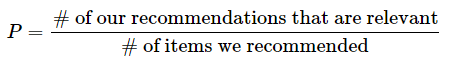

**Compared to Recall**
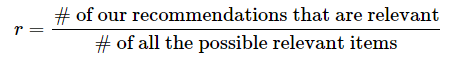

In [ ]:
from keras.metrics import AUC
from keras.metrics import Precision
from keras.metrics import Recall
from keras.optimizers import Adam

# Hyperparameter Tuning 

Bayesian Optimization Approach:
https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model

In [ ]:
!pip install -q -U keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def build_model(hp):
  # create model
  model = Sequential()

  # Define input layer, and first hidden layer
  # neurons for first hidden layer
  model.add(Dense(hp.Int('first layer', 
                                   min_value =20, 
                                   max_value = 1000,
                                   step = 50), input_dim=num_features, activation='relu')
  )

  # Define 2nd hidden (Dense) layers onward
  # Tune layers, neurons
  for i in range(hp.Int('num_layers', 2, 20)):
      model.add(Dense(units=hp.Int('units_' + str(i), 
                                   min_value =20, 
                                   max_value = 1000,
                                   step = 50),
                      activation='relu', 
                      name=f'Hidden{i}')
      )
      # Add drop out layers to 5th hidden layer
      if i == 4:
        model.add(Dropout(rate=0.25)
        )

  # Define output layer
  model.add(Dense(1, activation='sigmoid')
  )

  hp_learning_rate = hp.Choice('learning_rate', values=[0.2, 0.1, 1e-2, 1e-3, 1e-4])

  # Compile model
  # Tune learning rate at optimizer
  model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=hp_learning_rate), 
                  metrics=[AUC(),Precision(), Recall()]
                  )
  return model

# Hyperparameter Tuning using Random Search

In [ ]:
from kerastuner import Objective
from keras.callbacks import EarlyStopping

Try batch size = 500

In [ ]:
tuner = RandomSearch(
    build_model,
    objective = Objective("val_loss", direction="min"),
     max_trials=20,
     directory='olddir_5') # each time you run random search, chnage directory name

stop_early = EarlyStopping(monitor='val_loss', patience=7)

tuner.search(x=X_train_trf1,
             y=y_train,
             batch_size = 500,
             epochs = 100,
             validation_data=(X_val_trf1, y_val),
             callbacks=[stop_early]
             )


Trial 20 Complete [00h 00m 27s]
val_loss: 0.6927978992462158

Best val_loss So Far: 0.6173114776611328
Total elapsed time: 00h 31m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.hypermodel.build(tuner.get_best_hyperparameters()[0]).summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 420)               11760     
_________________________________________________________________
Hidden0 (Dense)              (None, 520)               218920    
_________________________________________________________________
Hidden1 (Dense)              (None, 120)               62520     
_________________________________________________________________
Hidden2 (Dense)              (None, 520)               62920     
_________________________________________________________________
Hidden3 (Dense)              (None, 920)               479320    
_________________________________________________________________
Hidden4 (Dense)              (None, 470)               432870    
_________________________________________________________________
dropout (Dropout)            (None, 470)               0

In [ ]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 420)               11760     
_________________________________________________________________
Hidden0 (Dense)              (None, 520)               218920    
_________________________________________________________________
Hidden1 (Dense)              (None, 120)               62520     
_________________________________________________________________
Hidden2 (Dense)              (None, 520)               62920     
_________________________________________________________________
Hidden3 (Dense)              (None, 920)               479320    
_________________________________________________________________
Hidden4 (Dense)              (None, 470)               432870    
_________________________________________________________________
dropout (Dropout)            (None, 470)               0

In [ ]:
best_model_rs = tuner.get_best_models()[0]

# After building a model against the training set, test that model
# against the val set.
result = best_model_rs.evaluate(x=X_val_trf1, 
                  y=y_val, 
                  batch_size=500)
for item in zip(best_model_rs.metrics_names, result):
  print (item[0], item[1])

83/83 [==============================] - 1s 6ms/step - loss: 0.6125 - auc: 0.7243 - precision: 0.6475 - recall: 0.6864
loss 0.6173114776611328
auc 0.7187758684158325
precision 0.6431270837783813
recall 0.6820800304412842


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'first layer': 420,
 'learning_rate': 0.001,
 'num_layers': 12,
 'units_0': 520,
 'units_1': 120,
 'units_10': 970,
 'units_11': 420,
 'units_12': 220,
 'units_13': 70,
 'units_14': 570,
 'units_15': 720,
 'units_16': 270,
 'units_2': 520,
 'units_3': 920,
 'units_4': 470,
 'units_5': 420,
 'units_6': 820,
 'units_7': 420,
 'units_8': 270,
 'units_9': 170}

In [ ]:
best_model_rs.save('best_model_rs.h5')
#best_model_rs = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/best_model_rs.h5')

Changing to Bayesian Optimization

In [ ]:
from kerastuner.tuners import BayesianOptimization

In [ ]:
class MyTuner(BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 100, 1000, step=150)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 50, 130, step = 20)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same arguments as the BayesianOptimization Tuner.
tuner_bo = MyTuner(build_model,
    objective = Objective("val_loss", direction="min"),
            max_trials=10,
            seed=42,
            executions_per_trial=5)

stop_early = EarlyStopping(monitor='val_loss', patience=7)

# Don't pass epochs or batch_size here, let the Tuner tune them.
tuner_bo.search(x=X_train_trf1,
             y=y_train,
             validation_data=(X_val_trf1, y_val),
             callbacks = [stop_early]
             )

Trial 10 Complete [00h 44m 26s]
val_loss: 0.6526498794555664

Best val_loss So Far: 0.6207305312156677
Total elapsed time: 05h 53m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_bo.get_best_hyperparameters()[0].values

{'batch_size': 400,
 'epochs': 50,
 'first layer': 70,
 'learning_rate': 0.0001,
 'num_layers': 8,
 'units_0': 870,
 'units_1': 20,
 'units_10': 820,
 'units_11': 970,
 'units_2': 720,
 'units_3': 620,
 'units_4': 870,
 'units_5': 720,
 'units_6': 820,
 'units_7': 320,
 'units_8': 170,
 'units_9': 770}

In [ ]:
best_model_bo = tuner_bo.get_best_models()[0]

# After building a model against the training set, test that model
# against the val set.
result = best_model_bo.evaluate(x=X_val_trf1, 
                  y=y_val, 
                  batch_size=500) #set batch size from previous block of code manually
for item in zip(best_model_bo.metrics_names, result):
  print (item[0], item[1])

83/83 [==============================] - 1s 5ms/step - loss: 0.6169 - auc: 0.7176 - precision: 0.6404 - recall: 0.6908
loss 0.6191622614860535
auc 0.7147683501243591
precision 0.6393564939498901
recall 0.6868894100189209


In [ ]:
best_hps_bo = tuner_bo.get_best_hyperparameters()[0]
best_model_bo = tuner_bo.hypermodel.build(best_hps_bo)
best_model_bo.summary() # equivalent to tuner_bo.get_best_models()[0].summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 70)                1960      
_________________________________________________________________
Hidden0 (Dense)              (None, 870)               61770     
_________________________________________________________________
Hidden1 (Dense)              (None, 20)                17420     
_________________________________________________________________
Hidden2 (Dense)              (None, 720)               15120     
_________________________________________________________________
Hidden3 (Dense)              (None, 620)               447020    
_________________________________________________________________
Hidden4 (Dense)              (None, 870)               540270    
_________________________________________________________________
dropout (Dropout)            (None, 870)               0

In [ ]:
# Export your models & weights. Remember to download them from the folder tab on the left
best_model_bo.save('best_model_bo.h5')
#best_model_bo = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/best_model_bo.h5').summary()

# Choose Neural Network based on validation precision

**Random Search Model**


In [ ]:
# Import your models 

##best_model_rs = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/best_model_rs.h5')
##best_model_bo = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/best_model_bo.h5')

In [ ]:
# The following variables are the hyperparameters.
lr = 0.001
epochs = 100
batch_size = 500


# Train the best model from  Random Search on training set.
hist = train_model(best_model_rs, X_train_trf1, y_train, 
                   X_val_trf1, y_val, 
                   epochs, batch_size)


Epoch 1/100
466/466 [==============================] - 4s 8ms/step - loss: 0.5966 - auc: 0.7420 - precision: 0.6663 - recall: 0.6751 - val_loss: 0.6181 - val_auc: 0.7188 - val_precision: 0.6537 - val_recall: 0.6551
Epoch 2/100
466/466 [==============================] - 3s 7ms/step - loss: 0.5960 - auc: 0.7427 - precision: 0.6671 - recall: 0.6755 - val_loss: 0.6196 - val_auc: 0.7174 - val_precision: 0.6456 - val_recall: 0.6728
Epoch 3/100
466/466 [==============================] - 3s 7ms/step - loss: 0.5958 - auc: 0.7430 - precision: 0.6711 - recall: 0.6642 - val_loss: 0.6226 - val_auc: 0.7190 - val_precision: 0.6521 - val_recall: 0.6544
Epoch 4/100
466/466 [==============================] - 3s 7ms/step - loss: 0.5954 - auc: 0.7435 - precision: 0.6673 - recall: 0.6770 - val_loss: 0.6200 - val_auc: 0.7185 - val_precision: 0.6450 - val_recall: 0.6790
Epoch 5/100
466/466 [==============================] - 3s 7ms/step - loss: 0.5943 - auc: 0.7445 - precision: 0.6694 - recall: 0.6751 - val_l

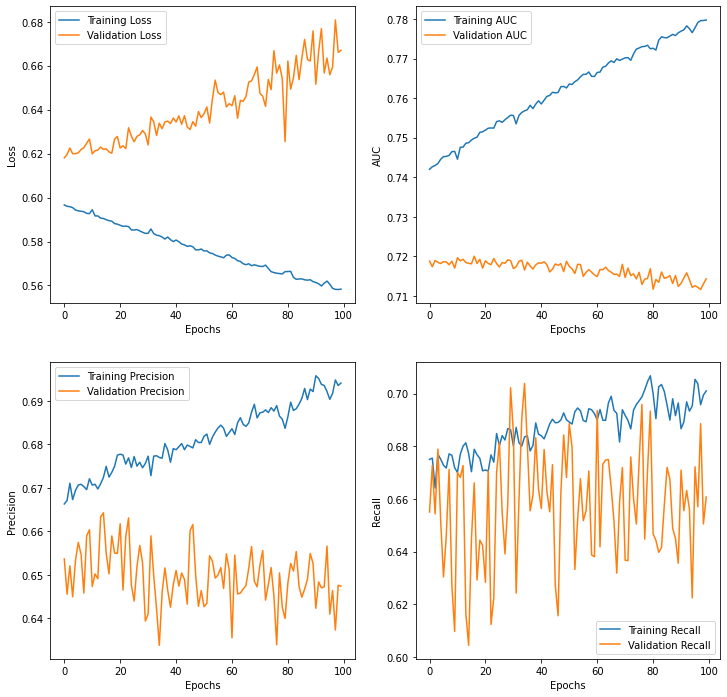

In [ ]:
# Plot a graph of the metric vs. epochs.
plot_curve(hist)

In [ ]:
# After building a model against the training set, test that model
# against the test set.
result = best_model_rs.evaluate(x=X_test_trf1, 
                  y=y_test, 
                  batch_size=batch_size)

for item in zip(best_model_rs.metrics_names, result):
  print(item[0], item[1])

137/137 [==============================] - 1s 5ms/step - loss: 0.6646 - auc: 0.7160 - precision: 0.6513 - recall: 0.6578
loss 0.6646450161933899
auc 0.7159740328788757
precision 0.6513491868972778
recall 0.6577535271644592


**Bayesian Optimized Model**

In [ ]:
#Import Model

##best_model_bo = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/best_model_bo.h5')

In [ ]:
# The following variables are the hyperparameters.
lr = 0.0001
epochs = 50
batch_size = 400


# Train the best model from  Random Search on training set.
hist = train_model(best_model_bo, X_train_trf1, y_train, 
                   X_val_trf1, y_val, 
                   epochs, batch_size)


Epoch 1/50
582/582 [==============================] - 5s 7ms/step - loss: 0.6726 - auc: 0.6115 - precision: 0.5829 - recall: 0.4957 - val_loss: 0.6521 - val_auc: 0.6659 - val_precision: 0.5999 - val_recall: 0.6738
Epoch 2/50
582/582 [==============================] - 4s 6ms/step - loss: 0.6492 - auc: 0.6673 - precision: 0.6182 - recall: 0.5984 - val_loss: 0.6440 - val_auc: 0.6781 - val_precision: 0.6057 - val_recall: 0.6944
Epoch 3/50
582/582 [==============================] - 4s 6ms/step - loss: 0.6430 - auc: 0.6784 - precision: 0.6203 - recall: 0.6211 - val_loss: 0.6396 - val_auc: 0.6844 - val_precision: 0.6269 - val_recall: 0.6278
Epoch 4/50
582/582 [==============================] - 4s 6ms/step - loss: 0.6389 - auc: 0.6850 - precision: 0.6260 - recall: 0.6288 - val_loss: 0.6380 - val_auc: 0.6874 - val_precision: 0.6442 - val_recall: 0.5628
Epoch 5/50
582/582 [==============================] - 4s 6ms/step - loss: 0.6366 - auc: 0.6885 - precision: 0.6298 - recall: 0.6207 - val_loss: 

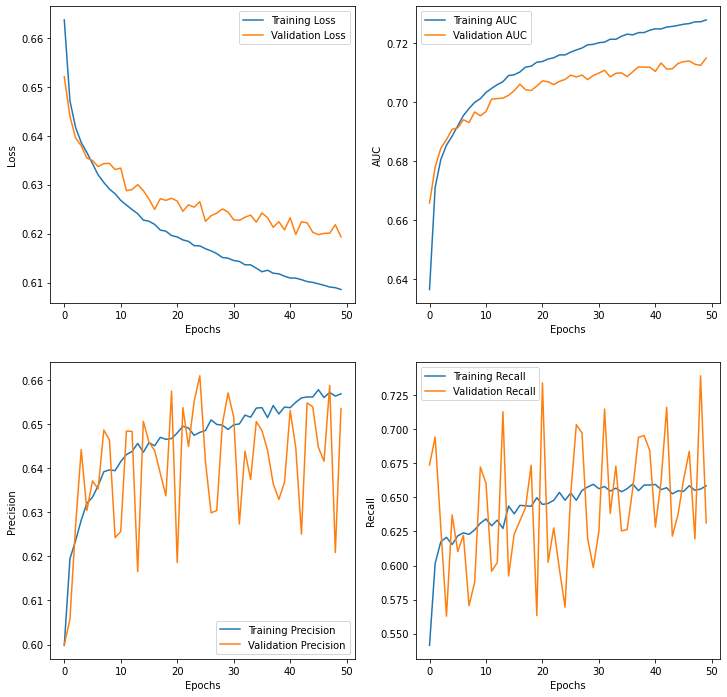

In [ ]:
# Plot a graph of the metric vs. epochs.
plot_curve(hist)

In [ ]:
# After building a model against the training set, test that model
# against the test set.
result = best_model_bo.evaluate(x=X_test_trf1, 
                  y=y_test, 
                  batch_size=batch_size)

for item in zip(best_model_bo.metrics_names, result):
  print(item[0], item[1])

172/172 [==============================] - 1s 4ms/step - loss: 0.6194 - auc: 0.7160 - precision: 0.6569 - recall: 0.6250
loss 0.6193670034408569
auc 0.7159577012062073
precision 0.656889021396637
recall 0.6249887347221375


# Tweak decision threshold

In [ ]:
from sklearn.metrics import precision_score
def get_precision_score(threshold, y_true, x_true, model):
  preds = model.predict(x_true)
  preds[preds >= threshold] = 1
  preds[preds < threshold] = 0
  return precision_score(y_true, preds)

get_precision_score(threshold = 0.8, y_true = y_val, x_true = X_val_trf1, model = best_model_rs)

0.7674775928297055

In [ ]:
get_precision_score(threshold = 0.8, y_true = y_test, x_true = X_test_trf1, model = best_model_rs)

0.7694884287454324

# Make recommendation

In [ ]:
X_test_complete.shape

(68433, 3)

In [ ]:
def show_recommendation(model, X_features_complete, X_trf1,
                        threshold):
  prediction = model.predict(X_trf1) # probabilities
  prediction[prediction >= threshold] = 1
  prediction[prediction< threshold] = 0
  prediction_ser = pd.DataFrame(prediction,
                                columns = ['Reccomend?'])

  # Combine
  movie_user = pd.concat([X_features_complete,prediction_ser], axis=1)

  # show primaryTitle, userID_ori & reccomend or not
  return movie_user.loc[movie_user['Reccomend?'] == 1]

show_recommendation(best_model_rs, X_test_complete, X_test_trf1,
                        0.8)

,primaryTitle,userId_ori,userId,Reccomend?
25,Up in the Air,20179,0.114643,1.0
26,Deliverance,90691,0.553238,1.0
79,Ocean's 11,31567,0.185478,1.0
111,Die Hard,106507,0.651616,1.0
116,Hud,90691,0.553238,1.0
...,...,...,...,...
68388,Fried Green Tomatoes,20585,0.117169,1.0
68399,Saving Private Ryan,106507,0.651616,1.0
68408,Deliverance,94154,0.574779,1.0
68426,Superman,2177,0.002668,1.0
